In [5]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime

In [7]:
# Select the dataset for the analysis
df = pd.read_csv("final_3label863.csv")
df = df[["sentence", "label"]]

# Show the data
df.head()

,sentence,label
0,usage and adverse effects of identified mtbfad...,1
1,long-term maternal administration of ritodrine...,1
2,/2021 assessed for eligibility (n=102) exclude...,1
3,35 this is an important consideration when com...,1
4,"thus, hospital admission in itself is a severe...",1


In [8]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["label"].value_counts())
print(40*'-')
nr_categories = len(df["label"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 862
----------------------------------------
Split by category:
2    398
1    300
0    164
Name: label, dtype: int64
----------------------------------------
Number of categories: 3


In [9]:
# You can adjust n:
n=100
print('Category: ',df['label'][n])
print(100*'-')
print('Text:')
print(df['sentence'][n])

Category:  1
----------------------------------------------------------------------------------------------------
Text:
although naltrexone/bupropion may increase blood pressure and should therefore not be used in patients with uncontrolled hypertension, no adverse signal for increased cardiovascular events was found in the interim analysis of a cardiovascular outcome trial 75 .in 2014, liraglutide 3 mg became the first glp1-based aom to be introduced to the us market for treatment of obesity in adults, and in 2020 was approved for weight management in adolescents aged 12 years and older with obesity (see related links).


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [11]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text
# Let's apply this function to the whole corpus
df["sentence_clean"] = df["sentence"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,sentence,label,sentence_clean
0,usage and adverse effects of identified mtbfad...,1,usage adverse effect identified mtbfadd32 pote...
1,long-term maternal administration of ritodrine...,1,longterm maternal administration ritodrine kno...
2,/2021 assessed for eligibility (n=102) exclude...,1,2021 assessed eligibility n102 excluded n5 scr...
3,35 this is an important consideration when com...,1,35 important consideration comparing outcome r...
4,"thus, hospital admission in itself is a severe...",1,thus hospital admission severe prognostic fact...


In [12]:
X = df['sentence_clean']
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['label'])

In [14]:
y_train.value_counts()/y.value_counts()


2    0.698492
1    0.700000
0    0.701220
Name: label, dtype: float64

In [15]:
corpus = X_train
#Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)
TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

In [16]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [17]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))
predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 92.0%
Accuracy Test data: 75.7%
Training time: 0.5s


In [18]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predicted_test_tfidf)
#matrix = matrix /matrix.astype(np.float).sum(axis=0)

207    1
607    2
676    2
283    1
346    2
      ..
463    2
589    2
553    2
856    0
814    0
Name: label, Length: 259, dtype: int64

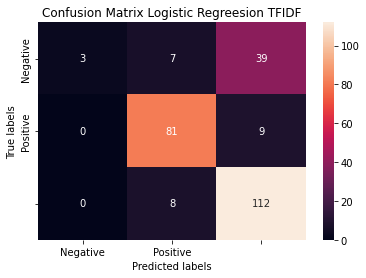

In [19]:
ax= plt.subplot()
conf_matrix = pd.DataFrame(matrix)
conf_matrix=sns.heatmap(matrix, annot=True, fmt='g', ax=ax);
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax.set_title('Confusion Matrix Logistic Regreesion TFIDF'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);
y_test

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_test_tfidf))


              precision    recall  f1-score   support

           0       1.00      0.06      0.12        49
           1       0.84      0.90      0.87        90
           2       0.70      0.93      0.80       120

    accuracy                           0.76       259
   macro avg       0.85      0.63      0.60       259
weighted avg       0.81      0.76      0.70       259



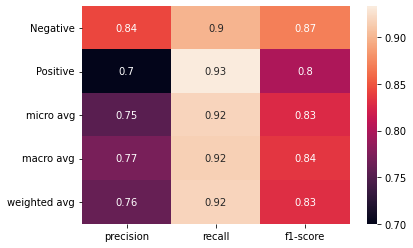

In [21]:
clf_report_nn = classification_report(y_test, predicted_test_tfidf, labels=[1, 2 ], target_names=['Negative', 'Positive'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_nn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report Neural Network'); 

In [22]:
# Renaming, Input -> X, Output -> y
X_tf = df['sentence']
y_tf_class = df['label']
#Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_tf_class)
y_tf = lab.transform(y_tf_class)
n=100
print('Coding of labels into a one-hot vector: ' +str(y_tf_class[n]) + ' is ', y_tf[n])

# Split into training and test data
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.5, random_state=42, stratify=df['label'])

Coding of labels into a one-hot vector: 1 is  [0 1 0]


In [23]:
corpus = X_tf_train
max_words = 5000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [24]:
max_len = 250
sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)
n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (431, 250)
----------------------------------------------------------------------------------------------------
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

In [25]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape
(300,)
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
      emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [26]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(3,activation='softmax', name='classification')(x)
model = models.Model(input_, output)
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 300)          1500300   
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               37920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 3)                 195       
                                                             

In [28]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs. 
import keras
from keras.callbacks import EarlyStopping
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   mode = 'min',
                                   patience = 50,
                                   restore_best_weights = True,
                                   verbose= 1)

In [29]:
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=32, shuffle=True, callbacks = [es], verbose=1, epochs=100, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()
training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/100
14/14 [==============================] - 10s 110ms/step - loss: 1.0268 - accuracy: 0.4896 - val_loss: 0.9996 - val_accuracy: 0.5035
Epoch 2/100
14/14 [==============================] - 0s 36ms/step - loss: 0.8743 - accuracy: 0.6218 - val_loss: 1.0459 - val_accuracy: 0.5754
Epoch 3/100
14/14 [==============================] - 1s 37ms/step - loss: 0.7192 - accuracy: 0.7193 - val_loss: 0.8226 - val_accuracy: 0.6682
Epoch 4/100
14/14 [==============================] - 1s 37ms/step - loss: 0.5580 - accuracy: 0.7889 - val_loss: 0.6958 - val_accuracy: 0.7541
Epoch 5/100
14/14 [==============================] - 0s 36ms/step - loss: 0.8414 - accuracy: 0.6450 - val_loss: 1.0680 - val_accuracy: 0.5661
Epoch 6/100
14/14 [==============================] - 1s 36ms/step - loss: 0.7043 - accuracy: 0.6984 - val_loss: 0.5766 - val_accuracy: 0.7517
Epoch 7/100
14/14 [==============================] - 0s 35ms/step - loss: 0.4433 - accuracy: 0.8329 - val_loss: 0.6101 - val_accuracy: 0.7193
Epoc

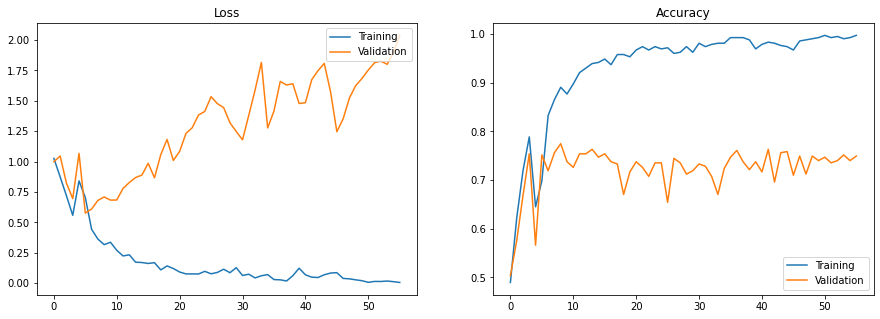

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [31]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 99.8%
Accuracy Test data: 74.9%
Training time: 56.5s


In [32]:
import tensorflow as tf
y_pred = tf.nn.softmax(model.predict(X_tf_test_seq))
y_pred_argmax = tf.math.argmax(y_pred, axis=1)
y_tf_test= y_tf_test.argmax(axis=1)
y_tf_test

array([1, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0,
       1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       0, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2,
       0, 2, 1, 2, 1, 1, 1, 0, 2, 2, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 0, 1,
       1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1,
       2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2,
       1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0, 0, 2, 2, 1, 2,
       1, 0, 1, 2, 0, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2,
       2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 0, 1, 2, 2,
       2, 2, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2,
       1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 2, 2, 2, 1, 2,
       1, 0, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1, 2, 2,

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
cm = confusion_matrix(y_pred_argmax, y_tf_test)
cm

array([[ 13,   3,  20],
       [  5, 140,   8],
       [ 64,   7, 171]])

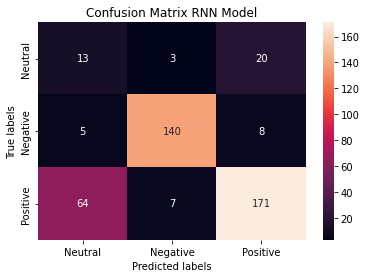

In [34]:
ax= plt.subplot()
conf_matrix = pd.DataFrame(cm)
conf_matrix=sns.heatmap(cm, annot=True, fmt='g', ax=ax);
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax.set_title('Confusion Matrix RNN Model'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Neutral', 'Negative', 'Positive']); ax.yaxis.set_ticklabels(['Neutral', 'Negative', 'Positive']);


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_tf_test, y_pred_argmax))

              precision    recall  f1-score   support

           0       0.36      0.16      0.22        82
           1       0.92      0.93      0.92       150
           2       0.71      0.86      0.78       199

    accuracy                           0.75       431
   macro avg       0.66      0.65      0.64       431
weighted avg       0.71      0.75      0.72       431



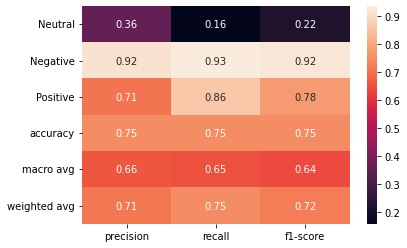

In [36]:
clf_report_nn = classification_report(y_tf_test, y_pred_argmax, labels=[0, 1, 2 ], target_names=['Neutral', 'Negative', 'Positive'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_nn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report RNN Network'); 

In [37]:
# Renaming, Input -> X, Output -> y
X_bert = df['sentence']
y_bert_class = df['label']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_bert_class)
y_bert = lab.transform(y_bert_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' +str(y_bert_class[n]) + ' is ', y_bert[n])
#Coding of labels into a one-hot vector: entertainment is  [0 1 0 0 0]
# distil-bert tokenizer
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_bert = [tokenizer_bert(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in X_bert]
X_bert = np.array(X_bert, dtype='int32')

Coding of labels into a one-hot vector: 1 is  [0 1 0]


In [38]:
# Train/test split
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert, y_bert, test_size=0.3, random_state=42, stratify=df['label'])
print('Shape of training data: ',X_bert_train.shape)
y_bert_test

Shape of training data:  (603, 512)


array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1,

In [ ]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
#dbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)
dbert = transformers.TFDistilBertModel.from_pretrained('siebert/sentiment-roberta-large-english', config=config, trainable=False)


In [ ]:
# Let's create a sampe of size 5 from the training data
sample = X_bert_train[0:5]
print('Object type: ', type(dbert(sample)))
print('Output format (shape): ',dbert(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert(sample)[0][:,0,:].shape)

In [ ]:
input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')
x = dbert(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(128, activation='relu', name='dense')(x)
#x = layers.Dropout(0.2, name='dropout2')(x)
#x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(3, activation='softmax', name='classification')(x)
dmodel = models.Model(inputs=input_ids_in, outputs = x)
dmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
dmodel.summary()

In [ ]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs. 
import keras
from keras.callbacks import EarlyStopping
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   mode = 'min',
                                   patience = 20,
                                   restore_best_weights = True,
                                   verbose= 1)

In [ ]:
start_time = datetime.now()
history = dmodel.fit(X_bert_train, y_bert_train, batch_size=32, shuffle=True, callbacks = [es], epochs=100, validation_data=(X_bert_test, y_bert_test), 
                     verbose=1)
end_time = datetime.now()

In [ ]:
#predictions = dmodel.predict(X_bert_test)
#predictions
import tensorflow as tf
y_pred = tf.nn.softmax(dmodel.predict(X_bert_test))
y_pred

In [ ]:
y_pred_argmax = tf.math.argmax(y_pred, axis=1)
y_bert1 = y_bert_test.argmax(axis=1)
y_bert1

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
ax= plt.subplot()
matrix = confusion_matrix(y_pred_argmax, y_bert1)
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)
ax.set_title('Confusion Matrix BERT-RNN Model'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Neutral', 'Negative', 'Positive']); ax.yaxis.set_ticklabels(['Neutral', 'Negative', 'Positive']);
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_argmax, y_bert1))

In [ ]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])